<figure>
  <IMG src="figures/logo-esi-sba.png" WIDTH=300 height="100" ALIGN="right">
</figure>

# Practical Lab Series on Network Sciences   
*By Dr. Belkacem KHALDI (b.khaldi@esi-sba.dz)*

## Notebook 2: Node Embeddings with GNNs - Skip-Gram

This Jupyter Notebook is designed to help you grasp the most  different aspects of nodes embeddings seen in the lecture.



In [1]:
%pip install  gensim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 1.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 819.8 kB/s eta 0:00:000:00:01
Note: you may need to restart the kernel to use updated packages.


## Import General Libraries

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

## Word2Vec

In [3]:

text = """Lorem ipsum dolor sit amet, consectetur
adipiscing elit. Nunc eu sem scelerisque, dictum eros
aliquam, accumsan quam. Pellentesque tempus, lorem ut
semper fermentum, ante turpis accumsan ex, sit amet
ultricies tortor erat quis nulla. Nunc consectetur ligula
sit amet purus porttitor, vel tempus tortor scelerisque.
Vestibulum ante ipsum primis in faucibus orci luctus
et ultrices posuere cubilia curae; Quisque suscipit
ligula nec faucibus accumsan. Duis vulputate massa sit
amet viverra hendrerit. Integer maximus quis sapien id
convallis. Donec elementum placerat ex laoreet gravida.
Praesent quis enim facilisis, bibendum est nec, pharetra
ex. Etiam pharetra congue justo, eget imperdiet diam
varius non. Mauris dolor lectus, interdum in laoreet
quis, faucibus vitae velit. Donec lacinia dui eget
maximus cursus. Class aptent taciti sociosqu ad litora
torquent per conubia nostra, per inceptos himenaeos.
Vivamus tincidunt velit eget nisi ornare convallis.
Pellentesque habitant morbi tristique senectus et netus
et malesuada fames ac turpis egestas. Donec tristique
ultrices tortor at accumsan.
""".split()


In [4]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec([text],
                  sg=1, # Skip-gram
                  vector_size=10,
                  min_count=0,
                  window=2,
                  seed=0)

print(f'Shape of W_embed: {model.wv.vectors.shape}')

Shape of W_embed: (121, 10)


In [5]:
model.train([text], total_examples=model.corpus_count,epochs=10)

(690, 1560)

In [6]:
print(f'Word embedding = {model.wv[0]}')

Word embedding = [ 0.07156403  0.03257632  0.00209916 -0.04374931 -0.03398107 -0.08656936
 -0.09047253 -0.0955243  -0.06482638  0.0660186 ]


## RandomWalk

In [7]:
random.seed(0)

class RandomWalk:
    def __init__(self, graph):
        self.graph = graph

    def random_walk(self, start, length):
        walk = [str(start)]  # starting node
        for i in range(length):
            neighbors = [node for node in self.graph.neighbors(start)]
            next_node = np.random.choice(neighbors, 1)[0]
            walk.append(str(next_node))
            start = next_node
        return walk

    def plot_graph(self):
        plt.figure(dpi=300)
        plt.axis('off')
        pos = nx.spring_layout(self.graph, seed=0)
        nx.draw_networkx(
            self.graph,
            pos=pos,
            node_size=600,
            cmap='coolwarm',
            font_size=14,
            font_color='white'
        )
        plt.show()


### Usage Example

['0', '1', '9', '1', '6', '2', '1', '2', '5', '4', '6']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


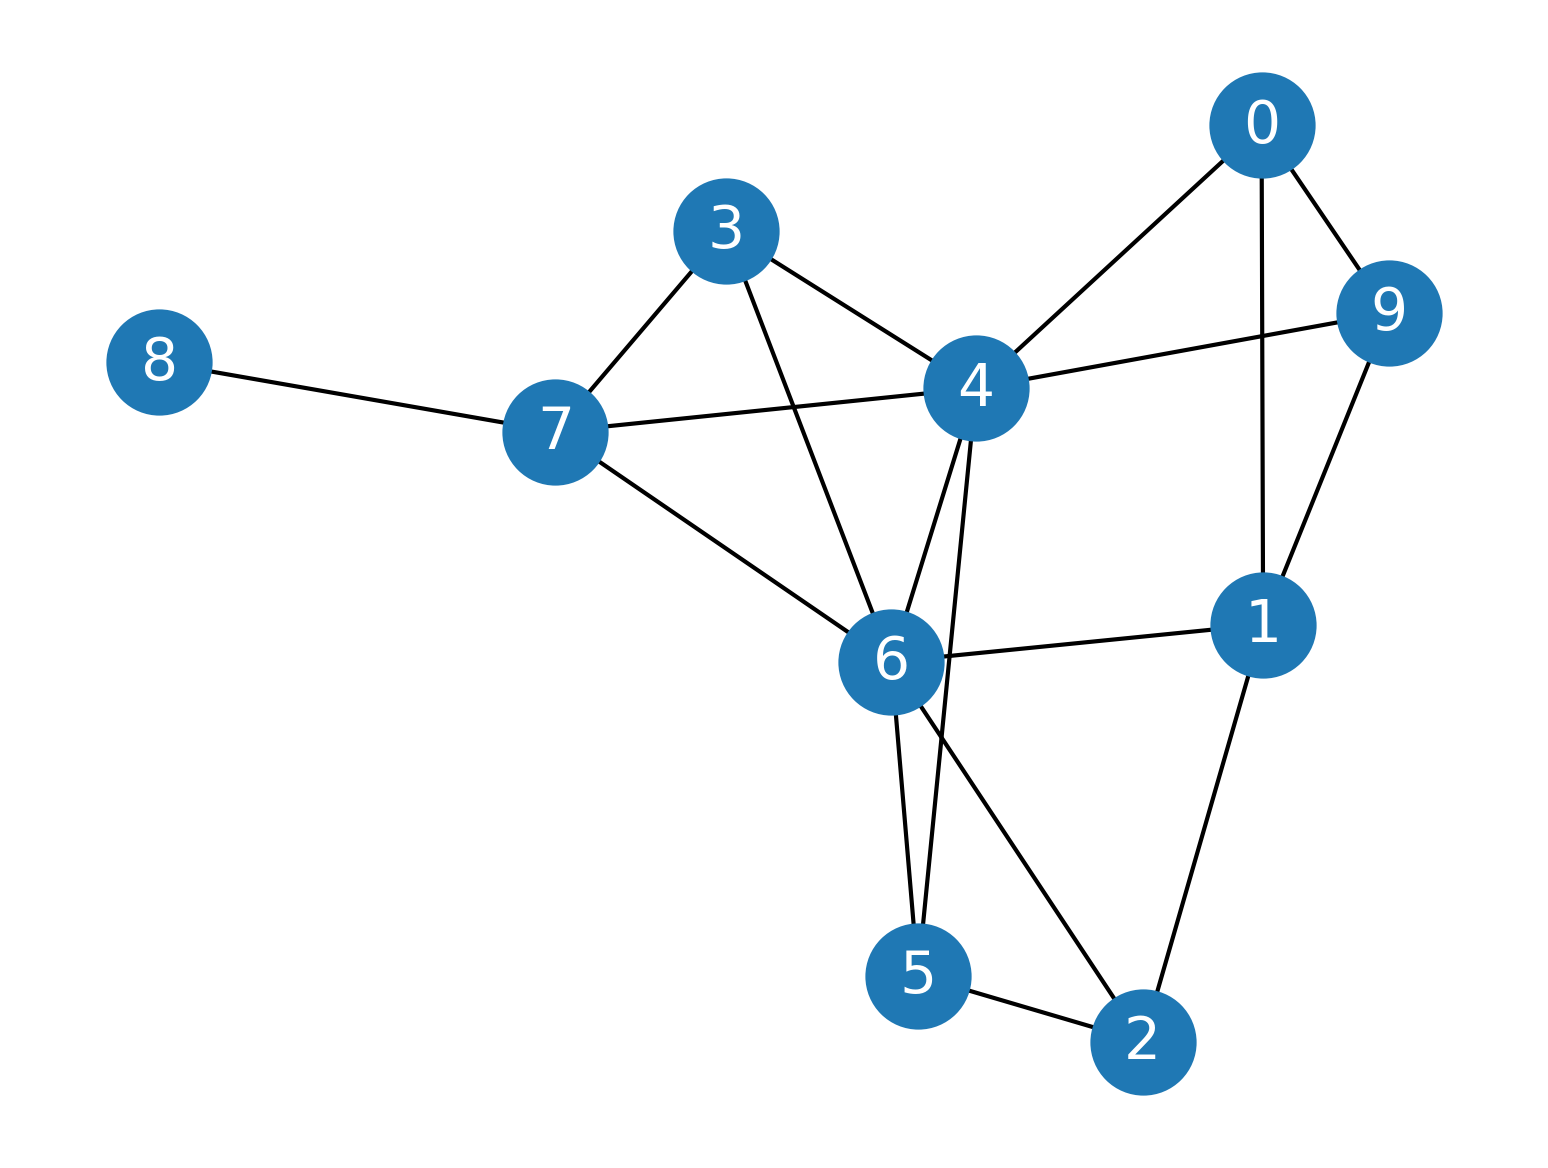

In [8]:
# Example usage
G = nx.erdos_renyi_graph(10, 0.3, seed=1, directed=False)
random_walker = RandomWalk(G)
walk_result = random_walker.random_walk(start=0, length=10)
print(walk_result)
random_walker.plot_graph()

## DeepWalk

In [32]:
random.seed(0)

class DeepWalk(RandomWalk):
    def __init__(self, graph):
        super().__init__(graph)

    def generate_random_walks(self, num_walks, walk_length):
        walks = []
        for node in self.graph.nodes:
            for _ in range(num_walks):
                walks.append(self.random_walk(node, walk_length))
        return walks

    def train_word2vec(self, walks, vector_size=100, window=10, epochs=30):
        from gensim.models.word2vec import Word2Vec

        model = Word2Vec(
            walks,
            hs=1,   # Hierarchical softmax
            sg=1,   # Skip-gram
            vector_size=vector_size,
            window=window,
            workers=1,
            seed=1
        )

        # Build vocabulary
        model.build_vocab(walks)

        # Train model
        model.train(walks, total_examples=model.corpus_count, epochs=epochs, report_delay=1)

        return model

    def visualize_tsne(self, model, labels):
        from sklearn.manifold import TSNE

        # Preprocess word vectors and label
        nodes_wv = np.array([model.wv.get_vector(str(i)) for i in range(len(model.wv))])

        # Train TSNE
        tsne = TSNE(
            n_components=2,
            learning_rate='auto',
            init='pca',
            random_state=0
        ).fit_transform(nodes_wv)

        # Plot TSNE
        plt.figure(figsize=(6, 6))
        plt.scatter(tsne[:, 0], tsne[:, 1], s=100, c=labels, cmap="coolwarm")
        plt.show()



### Visualization 
Using karate_club_graph graph

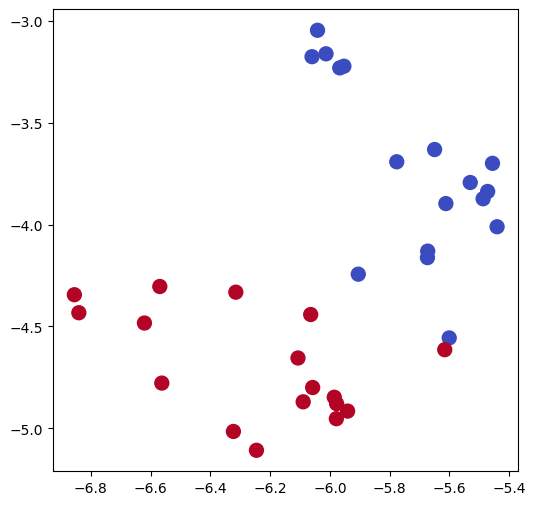

In [10]:
# Usage example
G = nx.karate_club_graph()
# Create a graph (for demonstration, you can use any other graph)


# Process labels (Mr. Hi = 0, Officer = 1)
labels = [1 if G.nodes[node]['club'] == 'Officer' else 0 for node in G.nodes]

# Create DeepWalk instance
deep_walker = DeepWalk(G)

# Generate random walks
walks = deep_walker.generate_random_walks(num_walks=100, walk_length=10)

# Train Word2Vec model
word2vec_model = deep_walker.train_word2vec(walks, vector_size=100, window=10, epochs=30)

# Visualize embeddings using t-SNE
deep_walker.visualize_tsne(word2vec_model, labels)


#### Application

In [11]:
print('Nodes that are the most similar to node 0:')
for similarity in word2vec_model.wv.most_similar(positive=['0']):
  print(f' {similarity}')

Nodes that are the most similar to node 0:
 ('4', 0.7025966644287109)
 ('10', 0.6635258793830872)
 ('6', 0.6459059119224548)
 ('5', 0.6229701042175293)
 ('7', 0.617043673992157)
 ('16', 0.614939272403717)
 ('11', 0.6050789952278137)
 ('17', 0.5815737843513489)
 ('3', 0.576694905757904)
 ('12', 0.5552679896354675)


## Pre-built DeepWalk

In [12]:
%pip install karateclub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 1.0 MB/s eta 0:00:00ta 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 5.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 kB 3.1 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.0/133.0 kB 2.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 4.0 MB/s eta 0:00:0000:0100:01
  Created wheel for karateclub: filename=karateclub-1.3.3-py3-none-any.whl size=101986 sha256=cee52ce3ad8f13c2bb6eb629d83a8bd6beec25ffe7cab8ba82ba85a765cfc214
  Stored in directory: /Users/hidayabouchouka/Lib

In [13]:
# Importing pre-built deepwalk libraries
from karateclub.node_embedding.neighbourhood.deepwalk import DeepWalk # DeepWalk implementation from KarateClub

# Load the karate club graph
G = nx.karate_club_graph()

# Create a DeepWalk instance with embedding dimensions 2
dw = DeepWalk(dimensions=2)

# Fit DeepWalk on the graph to generate node embeddings
dw.fit(G)

# Obtain the generated embeddings from DeepWalk
embeddings = dw.get_embedding()


### Visualization

/var/folders/m2/n0n7_x_90x1d33pwr19_wy800000gn/T/ipykernel_36960/2381588288.py:26: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(v[0],v[1], s=100,c=mapped_colors[x])


Text(0.5, 1.0, 'DeepWalk Nodes embedings')

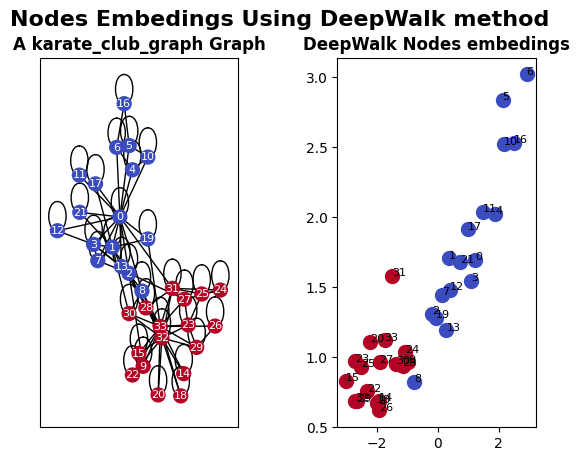

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2)
nx.draw_networkx(G,
                 pos=nx.spring_layout(G),
                 node_color=labels,
                 node_size=100,
                 cmap='coolwarm',
                 font_size=8,
                 font_color='white',
                 ax=axs[0]
                 )


import matplotlib.cm as cm

labels = np.array(labels)

# Normalize labels to range between 0 and 1
norm_labels = (labels - min(labels)) / (max(labels) - min(labels))

# Get colors from the 'coolwarm' colormap based on the normalized labels
mapped_colors = cm.coolwarm(norm_labels)

for x in G.nodes():
    v  = embeddings[x]
   
    axs[1].scatter(v[0],v[1], s=100,c=mapped_colors[x])
    axs[1].annotate(str(x), (v[0],v[1]), fontsize=8)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)
# Add a title to the overall plot
fig.suptitle('Nodes Embedings Using DeepWalk method', fontweight='bold', fontsize=16)

# Add titles to subplots
axs[0].set_title('A karate_club_graph Graph', fontweight='bold')
axs[1].set_title('DeepWalk Nodes embedings', fontweight='bold')

## Node2Vec

In [44]:
from sklearn.manifold import TSNE


class Node2Vec:
    def __init__(self, graph, dimensions=128, walk_length=30, num_walks=10, p=1.0, q=1.0):
        self.graph = graph
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.p = p
        self.q = q
        self.embeddings = None

    def _biased_random_walk(self, start_node):
        walk = [start_node]

        for _ in range(self.walk_length - 1):
            neighbors = list(self.graph.neighbors(walk[-1]))
            if len(neighbors) > 0:
                weights = [1.0 / self.p if n == walk[-1] else
                           1.0 / self.q if self.graph.has_edge(walk[-1], n) else
                           1.0 for n in neighbors]
                probabilities = np.array(weights) / np.sum(weights)
                walk.append(np.random.choice(neighbors, p=probabilities))
            else:
                break

        return [str(node) for node in walk]

    def generate_walks(self):
        walks = []

        for _ in range(self.num_walks):
            for node in self.graph.nodes():
                walks.append(self._biased_random_walk(node))

        return walks

    def train(self, walks):
        word2vec = Word2Vec(walks, vector_size=self.dimensions, window=5, min_count=0, sg=1, workers=4)
        self.embeddings = {str(node): word2vec.wv[str(node)] for node in self.graph.nodes()}

    def visualize_embeddings(self, G):
        if self.embeddings is None:
            print("Embeddings have not been trained yet.")
            return

        # Get binary cluster labels


        node_ids, embeddings = zip(*self.embeddings.items())
        embeddings = np.array(embeddings)

        # Perform t-SNE
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(embeddings)

        # Visualize
        plt.figure(figsize=(10, 8))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="coolwarm", alpha=0.7)
        for i, node_id in enumerate(node_ids):
            plt.annotate(node_id, (embeddings_2d[i, 0], embeddings_2d[i, 1]), alpha=0.7)
        plt.title('Node Embeddings Visualization using t-SNE')
        plt.colorbar()
        plt.show()



### Visualization

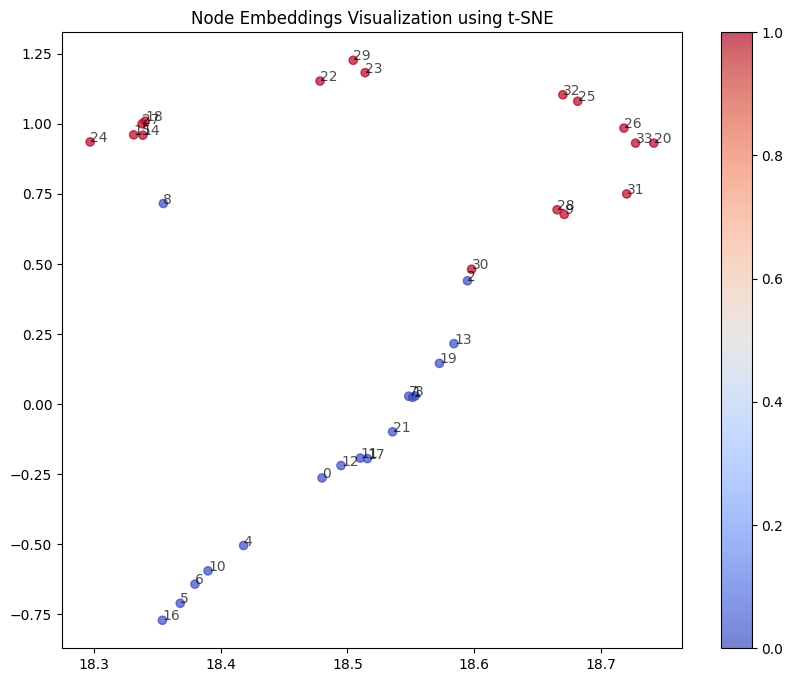

In [45]:
# Usage example
labels = [1 if G.nodes[node]['club'] == 'Officer' else 0 for node in G.nodes()]
G = nx.karate_club_graph()
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=10, p=1.0, q=1.0)
walks = node2vec.generate_walks()
node2vec.train(walks)
node2vec.visualize_embeddings(G)


## Pre-built Node2Vec

In [17]:
%pip install node2vec

Note: you may need to restart the kernel to use updated packages.


In [18]:
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt

node2vec = Node2Vec(G, dimensions=2)
model = node2vec.fit(window=10)

Computing transition probabilities:   0%|          | 0/34 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:00<00:00, 42.15it/s]


### Visualization

/var/folders/m2/n0n7_x_90x1d33pwr19_wy800000gn/T/ipykernel_36960/287017936.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[1].scatter(v[0],v[1], s=100,c=mapped_colors[x])


Text(0.5, 1.0, 'Node2Vec Nodes embedings')

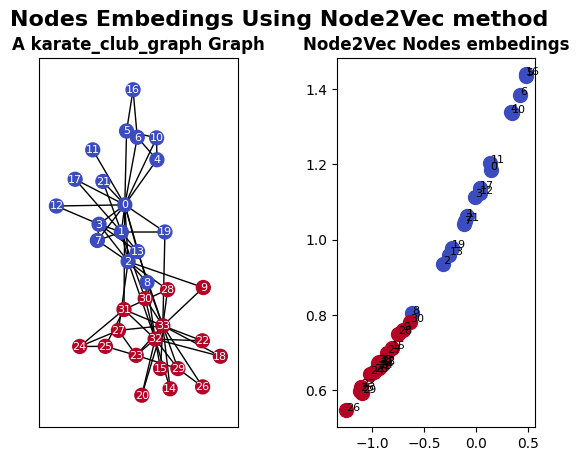

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=2)
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=0),
                 node_color=labels,
                 node_size=100,
                 cmap='coolwarm',
                 font_size=8,
                 font_color='white',
                 ax=axs[0]
                 )


import matplotlib.cm as cm

labels = np.array(labels)

# Normalize labels to range between 0 and 1
norm_labels = (labels - min(labels)) / (max(labels) - min(labels))

# Get colors from the 'coolwarm' colormap based on the normalized labels
mapped_colors = cm.coolwarm(norm_labels)

for x in G.nodes():
    v = model.wv.get_vector(str(x))
    axs[1].scatter(v[0],v[1], s=100,c=mapped_colors[x])
    axs[1].annotate(str(x), (v[0],v[1]), fontsize=8)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)
# Add a title to the overall plot
fig.suptitle('Nodes Embedings Using Node2Vec method', fontweight='bold', fontsize=16)

# Add titles to subplots
axs[0].set_title('A karate_club_graph Graph', fontweight='bold')
axs[1].set_title('Node2Vec Nodes embedings', fontweight='bold')

# Challenges:

## Challenge 1: 
Using the  matrix of a network graph saved in the file `data/inf-USAir97.mtx`:
- Create the graph using the follwing code:
```
from scipy.io import mmread
adj_mat = mmread("data/inf-USAir97.mtx")
graph = nx.from_scipy_sparse_matrix(adj_mat)
```

- Perform Nodes Embedings with the two skip-gram Based embedings  Methods: DeepWalk  and Node2Vec


In [21]:
#your solution

from scipy.io import mmread
adj_mat = mmread("data/inf-USAir97.mtx")
graph = nx.from_scipy_sparse_array(adj_mat)

## DeepWalk


In [33]:
# Create DeepWalk instance


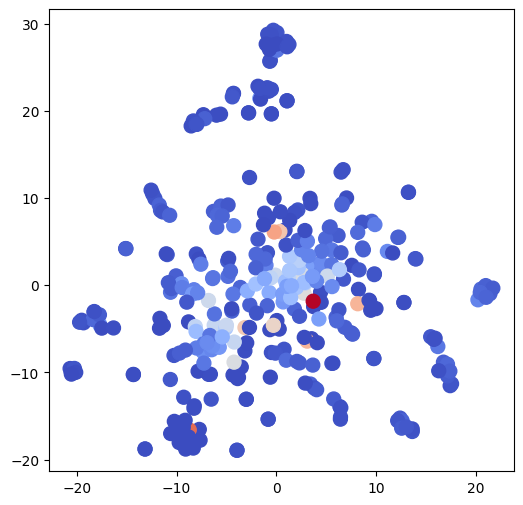

In [37]:
labels = [graph.degree(node) for node in graph.nodes]

deep_walker = DeepWalk(graph)
# Generate random walks
walks = deep_walker.generate_random_walks(num_walks=100, walk_length=10)

# Train Word2Vec model
word2vec_model = deep_walker.train_word2vec(walks, vector_size=100, window=10, epochs=30)

# Visualize embeddings using t-SNE
deep_walker.visualize_tsne(word2vec_model, labels)

## Node2Vec


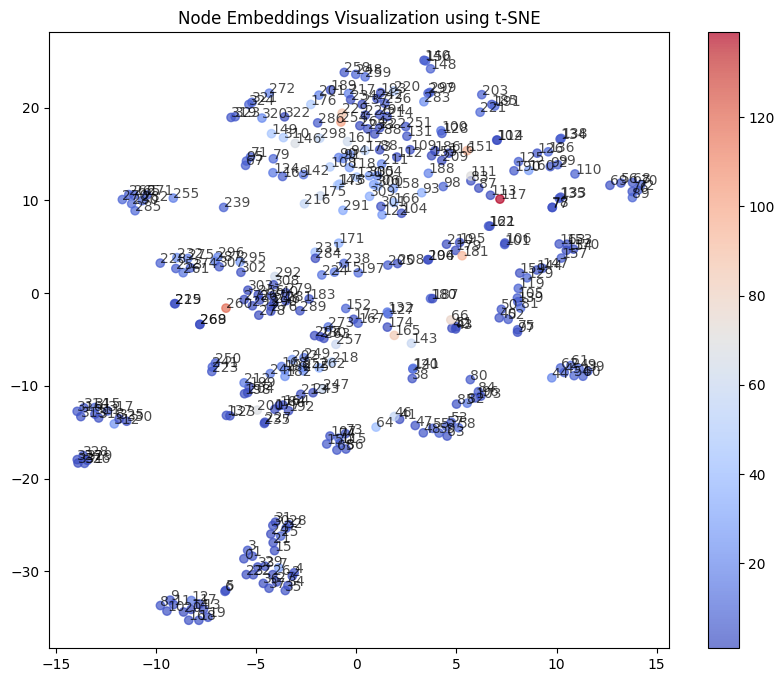

In [43]:

labels = [graph.degree(node) for node in graph.nodes]
node2vec = Node2Vec(graph, dimensions=128, walk_length=30, num_walks=10, p=1.0, q=1.0)
walks = node2vec.generate_walks()
node2vec.train(walks)
node2vec.visualize_embeddings(graph)
